# Module 2: Seasonal Crop Water Requirement (CWR), Green ETa and Blue ETa

**Last update: 21-Sept-2024**

[![](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORIPA/blob/main/Notebooks_beta/Module_1a_Seasonal_Aggregation_WaPOR_data.ipynb?target=\"_blank\")

### Introduction

This Notebook uses a script developed for the WaPOR project to calculate crop water requirements (CWR), green and blue actual water consumption (ETa).

### Workflow:

We will follow these steps to complete the calculations:

0. **Import Python Libraries**
1. **Import WaPOR Data** (kc, RET, PCP, seasonal ETa)
2. **Define Function for Temporal Aggregation**
3. **Define Crop Growing Period**
4. **Calculate Seasonal RET and ETp (ETc)**
5. **Calculate Seasonal Effective Precipitation**
6. **Calculate Seasonal Green ETa and Blue ETa**

### Data Used:

1. **Data Types**: PCP, RET, AETI, and kc
2. **Spatial Resolution**: Level 3
3. **Temporal Resolution**: Dekadal (PCP, RET) and Seasonal (AETI)
4. **Season Start Date**: SOS (Start of a season)
5. **Season End Date**:  EOS (End of a season)

The function `SumSeason` used in this Notebook is adapted from the [WaPORWP repository](https://github.com/wateraccounting/WAPORWP).

© 2020 Abebe Chukalla. Licensed under **CC BY 4.0 Creative Commons**.

© 2024 IHE Delft. Licensed under **CC BY-SA Creative Commons**.


---

## Step 0. Import modules/libraries

In [1]:
!pip install rioxarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 20.0 MB/s eta 0:00:00


In [3]:
!pip install gdal

In [4]:
import os                                 # Module for interacting with the operating system (e.g., file and directory handling)
import sys                                # Provides access to system-specific parameters and functions (e.g., command line arguments, environment)
import glob                               # Used to retrieve files/pathnames matching a specified pattern (e.g., *.tif for all TIFF files)
import re                                 # Regular expressions module used for searching, matching, and replacing strings (e.g., re.sub() for replacing substrings)
import rioxarray as rio                   # An extension of xarray that supports geospatial raster data handling (e.g., reading/writing GeoTIFFs)
import pandas as pd                       # Data analysis and manipulation library for working with structured data (e.g., DataFrames)
import numpy as np                        # Stands for 'Numerical Python', used for scientific computing with arrays (e.g., matrix operations, statistical functions)
import calendar                           # Module for working with calendar-related functions (e.g., generating dates, checking leap years)
import datetime                           # Module for handling date and time operations (e.g., converting strings to dates, date arithmetic)
from osgeo import gdal                    # GDAL (Geospatial Data Abstraction Library) used for reading and writing raster and vector geospatial data formats
from matplotlib import pyplot as plt      # A library for creating static, animated, and interactive visualizations in Python (e.g., plotting 2D graphs, images)

import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import rioxarray as rio  # Importing rioxarray for raster processing

### Upload or Mount Data

Upload your data or mount the data from your Google Drive.
- The dekadal resampled raster data (PCP, RET) and the seasonal (AETI)
- The kc, Crop coefficient, a dimensionless factor that adjusts the reference evapotranspiration (ETo) to account for the crop type, growth stage, and local environmental factors.

Make sure to update file paths as needed to point to the correct folder.

In [5]:
# upload resampled precipitation and reference evapotranspiration files.
from google.colab import files
uploaded = files.upload()

Saving PCPRETdata_resampled.zip to PCPRETdata_resampled.zip


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
!unzip '/content/PCPRETdata_resampled.zip' -d '/content'


Archive:  /content/PCPRETdata_resampled.zip
   creating: /content/PCP_resampled/
   creating: /content/RET_resampled/
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-10-21.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-11-21.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-21.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-02-21.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-11.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-02-11.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-12-21.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-12-01.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-01-21.tif  
  inflating: /content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-12-11.tif  
  inflating: /content/

In [7]:
# upload seasonal actual evapotranpiration files.
from google.colab import files
uploaded = files.upload()

Saving WaPORv3_M1_Seasonal.zip to WaPORv3_M1_Seasonal.zip


In [8]:
!unzip '/content/WaPORv3_M1_Seasonal' -d '/content'

Archive:  /content/WaPORv3_M1_Seasonal.zip
   creating: /content/content/output_M1a/AETI_season/
  inflating: /content/content/output_M1a/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M1a/NPP_season/
  inflating: /content/content/output_M1a/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M1a/T_season/
  inflating: /content/content/output_M1a/T_season/T_season1_2022-10-01_to_2023-04-30.tif  


In [9]:
# upload crop coefficient (kc) from Excel file (df_Kc.xlsx)
from google.colab import files
uploaded = files.upload()

Saving df_Kc.xlsx to df_Kc.xlsx


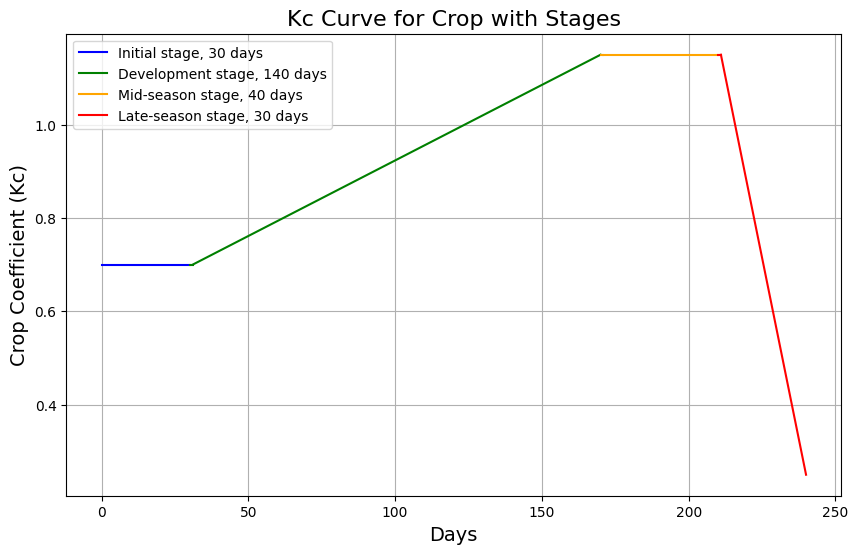

,Stages,Days,kc,Unnamed: 3,Crop stages,Duration_days,Kc,Stage_Label,Stage_Legend
0,Initial_s,0,0.70,NaN,Initial,30.0,0.70,Initial,"Initial stage, 30 days"
1,Initial_e,30,0.70,NaN,NaN,NaN,NaN,Initial,"Initial stage, 30 days"
2,development_s,31,0.70,NaN,Development,140.0,NaN,Development,"Development stage, 140 days"
3,development_e,170,1.15,NaN,NaN,NaN,1.15,Development,"Development stage, 140 days"
4,mid-season_s,171,1.15,NaN,Mid-season,40.0,NaN,Mid-season,"Mid-season stage, 40 days"
5,mid-season_e,210,1.15,NaN,NaN,NaN,NaN,Mid-season,"Mid-season stage, 40 days"
6,late-season_s,211,1.15,NaN,Late-season,30.0,NaN,Late-season,"Late-season stage, 30 days"
7,late-season_e,240,0.25,NaN,NaN,NaN,0.25,Late-season,"Late-season stage, 30 days"


In [29]:
# Step 1: Read the Kc data from an Excel file
dir_proj = os.path.split(os.getcwd())[0]  # Get the project directory
dir_data = "/content/"  # Set the data directory
df_kc = pd.read_excel(os.path.join(dir_proj, dir_data, 'df_Kc.xlsx'))  # Load crop data

# Step 2: Map and create stage labels with duration in days
df_kc['Stage_Label'] = df_kc['Stages'].replace({
    'Initial_s': 'Initial', 'Initial_e': 'Initial',
    'development_s': 'Development', 'development_e': 'Development',
    'mid-season_s': 'Mid-season', 'mid-season_e': 'Mid-season',
    'late-season_s': 'Late-season', 'late-season_e': 'Late-season'
})

# Create stage legend combining stage name and duration (first occurrence for each stage)
df_kc['Stage_Legend'] = df_kc.groupby('Stage_Label')['Duration_days'].transform('first')
df_kc['Stage_Legend'] = df_kc.apply(lambda row: f"{row['Stage_Label']} stage, {int(row['Stage_Legend'])} days"
                                    if pd.notna(row['Stage_Legend']) else f"{row['Stage_Label']} stage", axis=1)

# Step 3: Plotting with colors and labels
colors = {'Initial': 'blue', 'Development': 'green', 'Mid-season': 'orange', 'Late-season': 'red'}
plt.figure(figsize=(10, 6))

for i in range(1, len(df_kc['Days'])):
    plt.plot(df_kc['Days'][i-1:i+1], df_kc['kc'][i-1:i+1], color=colors[df_kc['Stage_Label'][i]], label=df_kc['Stage_Legend'][i])

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))  # Keep unique labels and handles
plt.legend(unique.values(), unique.keys(), loc='best')

# Add labels, title, and grid
plt.xlabel('Days', fontsize=14)
plt.ylabel('Crop Coefficient (Kc)', fontsize=14)
plt.title('Kc Curve for Crop with Stages', fontsize=16)
plt.grid(True)
plt.show()

df_kc

## Step 1. Import raster (WaPOR) data

In this section you will be importing the WaPOR data.

In [11]:
# import PCP and RET

dir_proj = os.path.split(os.getcwd())[0]
dir_data = "/content/"

input_folderPCP = os.path.join(dir_proj, dir_data, "PCP_resampled")
input_fhsPCP    = glob.glob(os.path.join(input_folderPCP, '*.tif'))

input_folderRET = os.path.join(dir_proj, dir_data, "RET_resampled")
input_fhsRET = sorted(glob.glob(input_folderRET + '/*.tif'))

input_fhsPCP , input_fhsRET

(['/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-10-21.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-11-21.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-21.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-02-21.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-04-11.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-02-11.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-12-21.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-12-01.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-01-21.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2022-12-11.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-01-01.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-03-11.tif',
  '/content/PCP_resampled/bb_L1-PCP-D_NONE_dekad_converted_2023-01-11.tif',
  '/content/

In [13]:
# import seasonal AETI

# Define the project directory and the output folder
dir_proj = os.path.split(os.getcwd())[0]
dir_data1 = "/content/content/output_M1a"                               # Specify the data directory (change the folder name to "output_M1b" as required)

input_folderETas = os.path.join(dir_proj, dir_data1, "AETI_season")     # Define the input folder path for seasonal AETI data
input_fhsETas    = glob.glob(os.path.join(input_folderETas, '*.tif'))   # Use glob to find all .tif files in the specified folder

input_fhsETas                                                           # Output the list of file paths

['/content/content/output_M1a/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif']

### This script defines (and create) the output folder.

In [14]:
# Define the project directory and output folder path
dir_proj = os.path.split(os.getcwd())[0]  # Get the parent directory of the current working directory
dir_data = r"/content/output_M2/"          # Specify the directory where the output will be stored

output_folderRET         = os.path.join(dir_proj, dir_data, "RET_season")
output_folderETp         = os.path.join(dir_proj, dir_data, "ETp_season")
output_folderETpmon      = os.path.join(dir_proj, dir_data, "2L3_ETp_month")
output_folderPCP         = os.path.join(dir_proj, dir_data, "PCP_season")
output_folderPCPmon      = os.path.join(dir_proj, dir_data, "PCP-month")
output_folderPCPeff      = os.path.join(dir_proj, dir_data, "PCPeff_season")
output_folderPCPeffmon      = os.path.join(dir_proj, dir_data, "2L3_PCPeff_month")
output_folderGreenBlueET = os.path.join(dir_proj, dir_data, "GreenBlueET_season")

# Make one if the folder does not exit
if not os.path.exists(output_folderRET):
    os.makedirs(output_folderRET)

if not os.path.exists(output_folderETp):
    os.makedirs(output_folderETp)

if not os.path.exists(output_folderPCP):
    os.makedirs(output_folderPCP)
if not os.path.exists(output_folderPCPeff):
    os.makedirs(output_folderPCPeff)

if not os.path.exists(output_folderGreenBlueET):
    os.makedirs(output_folderGreenBlueET)

if not os.path.exists(output_folderETpmon):
    os.makedirs(output_folderETpmon)
if not os.path.exists(output_folderPCPmon):
    os.makedirs(output_folderPCPmon)
if not os.path.exists(output_folderPCPeffmon):
    os.makedirs(output_folderPCPeffmon)

## Step 2. Define function for temporal aggregation

This script defines the SumSeason function, which will be used in the following sections to aggregate seasonal data.

© 2020 Abebe Chukalla. Licensed under CC BY 4.0 Creative Commons.

In [15]:
# Function to sum raster values between two specified dates (sowing and harvesting)
def SumSeason(input_fhs, sowing_date, harvesting_date):
    """
    This function sums the raster data that fall within the provided sowing and harvesting dates.

    Parameters:
    - input_fhs: List of file paths to the input raster files
    - sowing_date: The starting date of the season (as a datetime.date object)
    - harvesting_date: The ending date of the season (as a datetime.date object)

    Returns:
    - Sums: Aggregated raster data for the specified period
    """

    # Initialize the cumulative sum variable for raster data
    Sums = 0

    # Loop through each raster file
    for i, in_fh in enumerate(input_fhs):
        # Open the raster file and mask out invalid data using the fill value from the attributes
        ds = rio.open_rasterio(in_fh)
        ds = ds.where(ds != ds.attrs['_FillValue'])  # Ignore fill values in the raster data

        # Save the attributes of the first raster for later use (metadata such as start/end dates)
        if i == 0:
            attrs = ds.attrs

        # Extract the start and end dates of the raster from its attributes
        raster_startdate = datetime.datetime.strptime(ds.attrs['start_date'], '%Y-%m-%d').date()
        raster_enddate = datetime.datetime.strptime(ds.attrs['end_date'], '%Y-%m-%d').date()

        # Case 1: The entire raster period is within the sowing and harvesting dates
        if (raster_startdate >= sowing_date) and (raster_enddate <= harvesting_date):
            Sum = ds  # Use the full raster data
            Sums += Sum  # Accumulate it into the total sum

        # Case 2: Raster starts before sowing but ends within the growing season
        elif (raster_startdate < sowing_date) and (raster_enddate > sowing_date) and (raster_enddate < harvesting_date):
            # Add the fraction of the raster data that overlaps with the sowing date
            Sum = ds * ((raster_enddate - sowing_date) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

        # Case 3: Raster starts within the growing season but ends after the harvesting date
        elif (raster_startdate > sowing_date) and (raster_startdate < harvesting_date) and (raster_enddate > harvesting_date):
            # Add the fraction of the raster data that overlaps with the harvesting date
            Sum = ds * ((harvesting_date - raster_startdate) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

        # Case 4: Sowing and harvesting dates are both within the raster period
        elif (sowing_date >= raster_startdate) and (harvesting_date <= raster_enddate):
            # Add the fraction of the raster data that overlaps with both the sowing and harvesting dates
            Sum = ds * ((harvesting_date - sowing_date) / (raster_enddate - raster_startdate))
            Sums += Sum  # Accumulate the fractional sum

    # Update the raster attributes with new seasonal start and end dates
    attrs.update({
        'start_date': datetime.datetime.strftime(SOS, '%Y-%m-%d'),  # Seasonal start date
        'end_date': datetime.datetime.strftime(EOS, '%Y-%m-%d'),    # Seasonal end date
        'units': 'mm/season'  # Update units to reflect seasonal aggregation
    })

    # Remove unnecessary attributes to clean up the metadata
    del attrs['number_of_days']
    del attrs['temporal_resolution']
    del attrs['units_conversion_factor']

    # Assign the updated attributes to the summed raster
    Sums.attrs = attrs

    # Return the final aggregated raster data
    return Sums


## Step 3. Define seasons

Here the start (SOS) and end (EOS) dates for each season are defined.

In [16]:
season_periods = {
    'season1': {'SOS': '2022-10-01', 'EOS': '2023-04-30'}
}

## Step 4. Calculate seasonal Reference Evapotranspiration(RET), and Potentail crop water requirement ETp(ETc) = Kc*RET¶

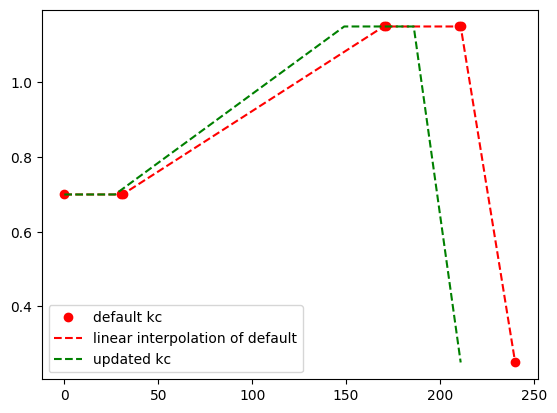

The mean & SD monthly ETp [mm] in 2022-10-01/2022-10-31 is 137.6 & 0.0
The mean & SD monthly RET [mm] in 2022-10-01/2022-10-31 is 195.1 & 0.0
The mean & SD monthly ETp [mm] in 2022-11-01/2022-11-30 is 170.5 & 0.0
The mean & SD monthly RET [mm] in 2022-11-01/2022-11-30 is 222.0 & 0.0
The mean & SD monthly ETp [mm] in 2022-12-01/2022-12-31 is 183.8 & 0.0
The mean & SD monthly RET [mm] in 2022-12-01/2022-12-31 is 208.7 & 0.0
The mean & SD monthly ETp [mm] in 2023-01-01/2023-01-31 is 227.5 & 0.0
The mean & SD monthly RET [mm] in 2023-01-01/2023-01-31 is 228.6 & 0.0
The mean & SD monthly ETp [mm] in 2023-02-01/2023-02-28 is 268.0 & 0.0
The mean & SD monthly RET [mm] in 2023-02-01/2023-02-28 is 243.2 & 0.0
The mean & SD monthly ETp [mm] in 2023-03-01/2023-03-31 is 327.1 & 0.0
The mean & SD monthly RET [mm] in 2023-03-01/2023-03-31 is 284.4 & 0.0
The mean & SD monthly ETp [mm] in 2023-04-01/2023-04-30 is 207.2 & 0.0
The mean & SD monthly RET [mm] in 2023-04-01/2023-04-30 is 296.0 & 0.0
The me

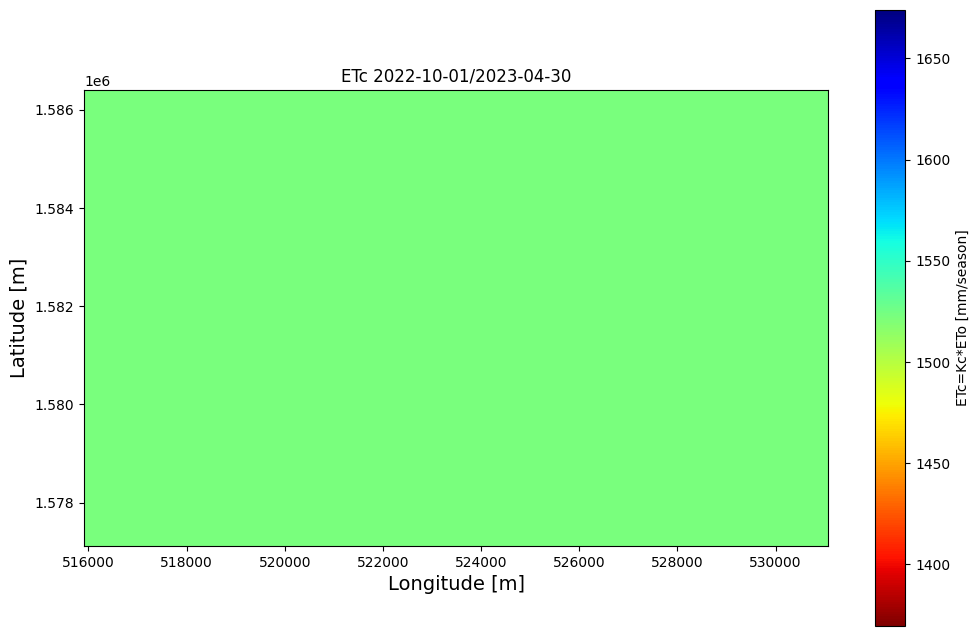

In [30]:
# Summary:
# This script calculates the seasonal reference evapotranspiration (RET) and the potential crop water requirement
# (ETp or ETc = Kc * RET) for each season. It adjusts the crop coefficient (Kc) curve based on the cropping period,
# calculates the monthly and seasonal RET and ETp values, and outputs the results in raster format.
# The script also visualizes the adjusted Kc curve and the resulting ETp map.

# Iterate over each season in the season_periods dictionary
for season, dates in season_periods.items():
    SOS = datetime.datetime.strptime(dates['SOS'], '%Y-%m-%d').date()  # Start date of the season (SOS)
    EOS = datetime.datetime.strptime(dates['EOS'], '%Y-%m-%d').date()  # End date of the season (EOS)

    # Adjust the crop coefficient (Kc) curve to match the specific cropping period
    defaultCropPeriod = df_kc.Days[df_kc.Stages == 'late-season_e']  # Default crop period length
    cropperiod = EOS - SOS  # Actual cropping period length for the season
    periodcorrection = cropperiod.days / defaultCropPeriod  # Correction factor
    df_kc['Days_corr'] = df_kc.apply(lambda row: (row['Days'] * periodcorrection).round(0), axis=1)  # Adjust days
    df_kc['Date'] = df_kc.apply(lambda row: SOS + datetime.timedelta(days=row['Days_corr']), axis=1)  # Add corrected dates

    # Interpolate Kc values over the corrected crop period
    xcorr = df_kc['Days_corr']
    y = df_kc['kc']
    fkcnew = interp1d(xcorr, y, kind='linear')

    # Plot Kc curves (default and adjusted) for the first season only
    if season == 'season1':
        x = df_kc['Days']
        fkcdefault = interp1d(x, y, kind='linear')
        plt.plot(x, y, 'ro', x, fkcdefault(x), 'r--', xcorr, fkcnew(xcorr), 'g--')
        plt.legend(['default kc', 'linear interpolation of default', 'updated kc'], loc='best')
        plt.show()

    # Initialize cumulative seasonal RET (ETo) and ETp (ETc)
    seasonETo = 0
    seasonETp = 0
    date_s = SOS

    # Loop through each month in the season to calculate monthly RET and ETp
    while date_s < EOS:
        # Helper functions to get the first and last day of the month
        def first_day_of_month(date):
            return date.replace(day=1)

        def last_day_of_month(date):
            return date.replace(day=31) if date.month == 12 else date.replace(month=date.month + 1, day=1) - datetime.timedelta(days=1)

        startdate = max(first_day_of_month(date_s), SOS)
        enddate = min(last_day_of_month(date_s), EOS)

        # Interpolate Kc for the start and end of the month, then compute the average Kc
        kc_s = fkcnew((startdate - SOS).days)
        kc_f = fkcnew((enddate - SOS).days)
        kc_m = (kc_s + kc_f) / 2

        # Calculate monthly ETo and ETp
        ET0m = SumSeason(input_fhsRET, startdate, enddate)  # Sum of reference evapotranspiration (RET) for the month
        ETp = kc_m * ET0m  # Monthly potential crop water requirement (ETp = Kc * RET)

        # Move to the next month
        date_s = enddate + datetime.timedelta(days=1)

        # Accumulate monthly RET and ETp for the season
        seasonETo += ET0m
        seasonETp += ETp

        # Save the monthly ETp as a raster file
        out_fh = os.path.join(output_folderETpmon, f'ETcmon_{startdate}_to_{enddate}.tif')
        seasonETp.rio.to_raster(out_fh)

        # Print the monthly statistics for RET and ETp
        print(f'The mean & SD monthly ETp [mm] in {startdate}/{enddate} is {np.nanmean(ETp).round(1)} & {np.nanstd(ETp).round(1)}')
        print(f'The mean & SD monthly RET [mm] in {startdate}/{enddate} is {np.nanmean(ET0m).round(1)} & {np.nanstd(ET0m).round(1)}')

    # Save the seasonal RET and ETp as raster files
    out_fh = os.path.join(output_folderRET, f'RET_{season}_{dates["SOS"]}_to_{dates["EOS"]}.tif')
    seasonETo.rio.to_raster(out_fh)
    print(f'The mean & SD seasonal RET [mm] in {SOS}/{EOS} is {np.nanmean(seasonETo).round(1)} & {np.nanstd(seasonETo).round(1)}')

    out_fh = os.path.join(output_folderETp, f'ETc_{season}_{dates["SOS"]}_to_{dates["EOS"]}.tif')
    seasonETp.rio.to_raster(out_fh)
    print(f'The mean & SD seasonal ETc [mm] in {SOS}/{EOS} is {np.nanmean(seasonETp).round(1)} & {np.nanstd(seasonETp).round(1)}')

    # Plot the raster map of seasonal ETp
    spatial_extent = (seasonETp.x.min(), seasonETp.x.max(), seasonETp.y.min(), seasonETp.y.max())
    plt.figure(figsize=(12, 8))
    plt.imshow(seasonETp[0], cmap='jet_r', vmin=np.nanmin(seasonETp), vmax=np.nanmax(seasonETp), extent=spatial_extent)
    plt.colorbar(shrink=1, label='ETc=Kc*ETo [mm/season]')
    plt.xlabel('Longitude [m]', fontsize=14)
    plt.ylabel('Latitude [m]', fontsize=14)
    plt.title(f'ETc {SOS}/{EOS}', fontsize=12)
    plt.clim()
    plt.show()


## Step 5. Calculate monthly and seasonal precipitaiton (P)&effective precipitation (Peff)
USDA Soil Conservation Service: Formula developed by USCS, where effective rainfall can be calculated according to:  
Monthly step:  
* Peff = Pmonth * (125 - 0.2 * Pmonth) / 125 for Pmonth <= 250 mm
* Peff = 125 + 0.1 * Pmonth for Pmonth > 250 mm

np.where(PCP<=250, PCP*(126-0.2*PCP)/125, np.where(PCP>250, 125 + 0.1*PCP, np.nan)

The mean & SD monthly PCP [mm] in 2022-10-01/2022-10-31 is 14.8 & 2.5
The mean & SD monthly Peff [mm] in 2022-10-01/2022-10-31 is 14.4 & 2.4
The mean & SD monthly PCP [mm] in 2022-11-01/2022-11-30 is 0.0 & 0.0
The mean & SD monthly Peff [mm] in 2022-11-01/2022-11-30 is 0.0 & 0.0
The mean & SD monthly PCP [mm] in 2022-12-01/2022-12-31 is 0.0 & 0.0
The mean & SD monthly Peff [mm] in 2022-12-01/2022-12-31 is 0.0 & 0.0
The mean & SD monthly PCP [mm] in 2023-01-01/2023-01-31 is 0.0 & 0.0
The mean & SD monthly Peff [mm] in 2023-01-01/2023-01-31 is 0.0 & 0.0
The mean & SD monthly PCP [mm] in 2023-02-01/2023-02-28 is 0.0 & 0.0
The mean & SD monthly Peff [mm] in 2023-02-01/2023-02-28 is 0.0 & 0.0
The mean & SD monthly PCP [mm] in 2023-03-01/2023-03-31 is 0.0 & 0.0
The mean & SD monthly Peff [mm] in 2023-03-01/2023-03-31 is 0.0 & 0.0
The mean & SD monthly PCP [mm] in 2023-04-01/2023-04-30 is 0.1 & 0.3
The mean & SD monthly Peff [mm] in 2023-04-01/2023-04-30 is 0.1 & 0.3
The mean & SD seasonal PC

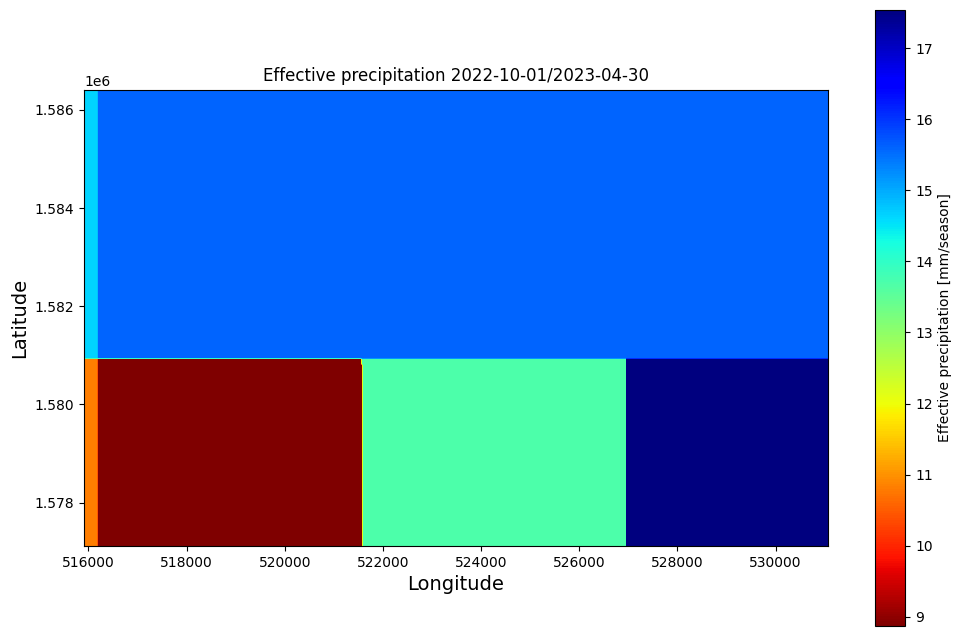

In [31]:
"""

This script processes precipitation data (PCP) and calculates effective precipitation (Peff) for each season.
It extracts geospatial info from the first PCP raster, computes monthly and seasonal PCP/Peff values, and
outputs them as raster files, along with Peff visualizations.
"""

# Collect GeoInfo from the first raster file in PCP
in_fh = input_fhsPCP[0]  # First precipitation file
ds = rio.open_rasterio(in_fh)  # Open the raster file
crs = ds.rio.crs  # Get CRS (Coordinate Reference System) of raster
NDV = ds.attrs.get('_FillValue', np.nan)  # Get NoDataValue from the raster metadata

# Iterate over each season in season_periods
for season, dates in season_periods.items():
    SOS = datetime.datetime.strptime(dates['SOS'], '%Y-%m-%d').date()  # Start date of the season (SOS)
    EOS = datetime.datetime.strptime(dates['EOS'], '%Y-%m-%d').date()  # End date of the season (EOS)

    seasonPCP, seasonPeff = None, None  # Initialize for seasonal PCP and Peff

    date_s = SOS
    while date_s < EOS:
        # Functions to get the first and last day of a month
        def first_day_of_month(date):
            return date.replace(day=1)

        def last_day_of_month(date):
            # Special case for December (month 12)
            return date.replace(day=31) if date.month == 12 else date.replace(month=date.month + 1, day=1) - datetime.timedelta(days=1)

        startdate = max(first_day_of_month(date_s), SOS)  # Start date for current month
        enddate = min(last_day_of_month(date_s), EOS)  # End date for current month

        # Calculate monthly PCP and Peff
        PCPm = SumSeason(input_fhsPCP, startdate, enddate)  # Monthly precipitation
        Peffm = np.where(PCPm <= 250, PCPm * (125 - 0.2 * PCPm) / 125, 125 + 0.1 * PCPm)  # Effective precipitation

        # Convert Peffm to a rioxarray DataArray with the correct attributes
        Peffm_da = ds.copy(data=Peffm)

        # Move to the next month
        date_s = enddate + datetime.timedelta(days=1)

        # Accumulate monthly values into seasonal totals
        seasonPCP = PCPm if seasonPCP is None else seasonPCP + PCPm
        seasonPeff = Peffm_da if seasonPeff is None else seasonPeff + Peffm_da

        # Save monthly PCP and Peff to raster format
        out_fh = os.path.join(output_folderPCPmon, f'PCPmon_{startdate}_to_{enddate}.tif')
        PCPm.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save monthly PCP
        print(f'The mean & SD monthly PCP [mm] in {startdate}/{enddate} is {np.nanmean(PCPm).round(1)} & {np.nanstd(PCPm).round(1)}')

        out_fh = os.path.join(output_folderPCPeffmon, f'PCPeffmon_{startdate}_to_{enddate}.tif')
        Peffm_da.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save monthly Peff
        print(f'The mean & SD monthly Peff [mm] in {startdate}/{enddate} is {np.nanmean(Peffm).round(1)} & {np.nanstd(Peffm).round(1)}')

    # Save seasonal PCP and Peff to raster format
    out_fh = os.path.join(output_folderPCP, f'PCP_{season}_{SOS}_to_{EOS}.tif')
    seasonPCP.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save seasonal PCP
    print(f'The mean & SD seasonal PCP [mm] in {SOS}/{EOS} is {np.nanmean(seasonPCP).round(1)} & {np.nanstd(seasonPCP).round(1)}')

    out_fh = os.path.join(output_folderPCPeff, f'PCPeff_{season}_{SOS}_to_{EOS}.tif')
    seasonPeff.rio.to_raster(out_fh, nodata=NDV, crs=crs)  # Save seasonal Peff
    print(f'The mean & SD seasonal Peff [mm] in {SOS}/{EOS} is {np.nanmean(seasonPeff).round(1)} & {np.nanstd(seasonPeff).round(1)}')

    # Plot the seasonal Peff raster map with calculated spatial extent
    spatial_extent = (seasonPeff.x.min(), seasonPeff.x.max(), seasonPeff.y.min(), seasonPeff.y.max())
    plt.figure(figsize=(12, 8))
    plt.imshow(seasonPeff.squeeze(), cmap='jet_r', vmin=np.nanmin(seasonPeff), vmax=np.nanmax(seasonPeff), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Effective precipitation [mm/season]')
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(f'Effective precipitation {SOS}/{EOS}', fontsize=12)
    plt.show()

## Step 6. Calculate seasonal geen and blue water consumption, Green ETa and Blue ETa
* Green ETa = min (Pe, ETa)
* Blue ETa  = max (0, ETa - Pe)
* where ETa is actual evapotranpiration and Pe is effective precipitaiton

In [36]:
# Define the project directory and output folder path
dir_proj = os.path.split(os.getcwd())[0]   # Get the parent directory of the current working directory
dir_data = r"/content/output_M2/"          # Specify the directory of the folder/file
dir_data1 = "/content/content/output_M1a"  # Specify the directory of the folder/file

input_folderPeff= os.path.join(dir_proj, dir_data, "PCPeff_season")
input_fhsPeff   = sorted(glob.glob(input_folderPeff + '/*.tif'))

input_folderETa = os.path.join(dir_proj, dir_data1, "AETI_season")
input_fhsETa    = sorted(glob.glob(input_folderETa + '/*.tif'))

input_fhsPeff, input_fhsETa

(['/content/output_M2/PCPeff_season/PCPeff_season1_2022-10-01_to_2023-04-30.tif'],
 ['/content/content/output_M1a/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif'])

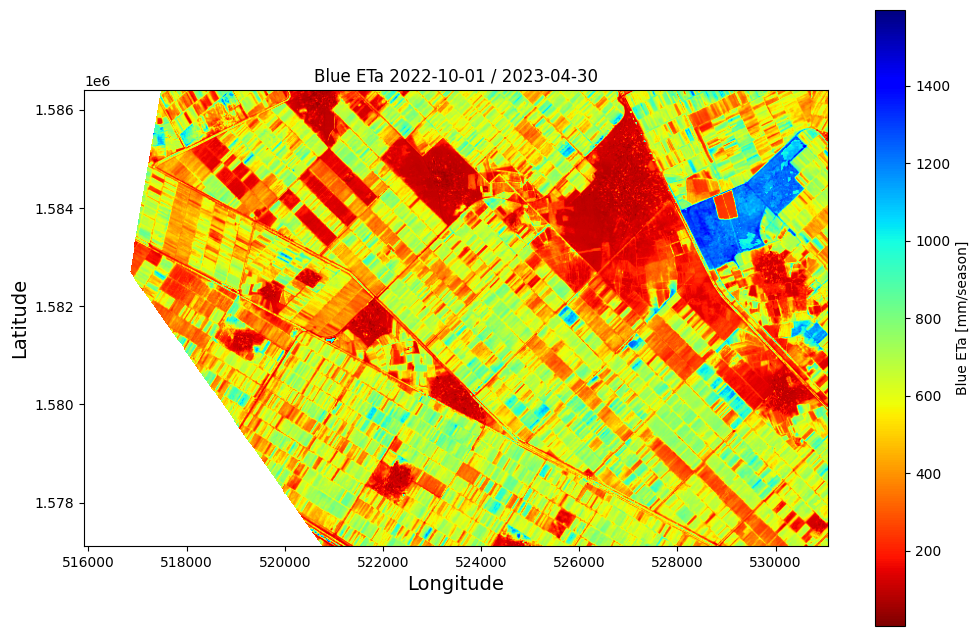

<ipython-input-44-84f86d7ad669>:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df1], ignore_index=True)  # Concatenate new data to the dataframe


,Season,GreenETa_mean,GreenETa_SD,BlueETa_mean,BlueETa_SD,ETa_mean,ETa_SD
0,2022-10-01 / 2023-04-30,15.056515,1.984772,521.594321,246.781962,536.650836,246.645156


In [44]:
"""
This script processes effective precipitation (Peff) and actual evapotranspiration (ETa) raster files
to compute GreenETa (the portion of ETa met by precipitation) and BlueETa (the portion of ETa met by irrigation or other sources).
It saves the results as raster files and visualizes BlueETa as a map.
Additionally, it calculates summary statistics (mean, standard deviation) for each season and stores them in a DataFrame.
"""

# Initiate an empty dataframe to store seasonal ETa statistics
df = pd.DataFrame(columns=['Season', 'GreenETa_mean', 'GreenETa_SD', 'BlueETa_mean', 'BlueETa_SD', 'ETa_mean', 'ETa_SD'])

# Loop through the pairs of Peff (effective precipitation) and ETa (actual evapotranspiration) raster files
for i, (in_fhPeff, in_fhETa) in enumerate(zip(input_fhsPeff, input_fhsETa)):
    # Open Peff and ETa raster files as DataArrays using rioxarray
    Peff = rio.open_rasterio(in_fhPeff)
    ETa = rio.open_rasterio(in_fhETa)

    # Calculate GreenETa (portion of ETa met by precipitation) and BlueETa (portion of ETa from other sources)
    GreenETa = np.where(Peff <= ETa, Peff, ETa)  # GreenETa = min(Peff, ETa)
    BlueETa = np.where(Peff >= ETa, 0, ETa - Peff)  # BlueETa = max(0, ETa - Peff)

    # Convert GreenETa and BlueETa back to DataArray for saving with proper attributes
    GreenETa_da = Peff.copy(data=GreenETa)
    BlueETa_da = Peff.copy(data=BlueETa)

    # Extract season start (SOS) and end (EOS) dates from the season_periods dictionary
    SOS = datetime.datetime.strptime(season_periods['season1']['SOS'], '%Y-%m-%d').date()
    EOS = datetime.datetime.strptime(season_periods['season1']['EOS'], '%Y-%m-%d').date()
    season = f"{SOS} / {EOS}"

    # Save GreenETa as a raster file
    out_fh = os.path.join(output_folderGreenBlueET, f'GreenETa_{SOS}_to_{EOS}.tif')
    GreenETa_da.rio.to_raster(out_fh, nodata=Peff.rio.nodata, crs=Peff.rio.crs)

    # Save BlueETa as a raster file
    out_fh = os.path.join(output_folderGreenBlueET, f'BlueETa_{SOS}_to_{EOS}.tif')
    BlueETa_da.rio.to_raster(out_fh, nodata=Peff.rio.nodata, crs=Peff.rio.crs)

    # Plot the BlueETa raster map (visualization)
    spatial_extent = (BlueETa_da.x.min(), BlueETa_da.x.max(), BlueETa_da.y.min(), BlueETa_da.y.max())  # Get spatial extent
    plt.figure(figsize=(12, 8))
    plt.imshow(BlueETa_da.squeeze(), cmap='jet_r', vmin=np.nanmin(BlueETa), vmax=np.nanmax(BlueETa), extent=spatial_extent)
    plt.colorbar(shrink=1, label='Blue ETa [mm/season]')
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.title(f'Blue ETa {SOS} / {EOS}', fontsize=12)
    plt.show()

    # Collect summary statistics (mean, standard deviation) for each variable
    data = {
        'Season': season,
        'GreenETa_mean': np.nanmean(GreenETa),
        'GreenETa_SD': np.nanstd(GreenETa),
        'BlueETa_mean': np.nanmean(BlueETa),
        'BlueETa_SD': np.nanstd(BlueETa),
        'ETa_mean': np.nanmean(ETa),
        'ETa_SD': np.nanstd(ETa)
    }

    # Convert the statistics to a DataFrame row and append to the main DataFrame
    df1 = pd.DataFrame([data])
    df = pd.concat([df, df1], ignore_index=True)  # Concatenate new data to the dataframe

# Display the final dataframe with seasonal statistics
df


In [45]:
# export(save) the dataframe to excel
df.to_excel(os.path.join(output_folderGreenBlueET,   'Green&BlueETa.xlsx'))
df

,Season,GreenETa_mean,GreenETa_SD,BlueETa_mean,BlueETa_SD,ETa_mean,ETa_SD
0,2022-10-01 / 2023-04-30,15.056515,1.984772,521.594321,246.781962,536.650836,246.645156


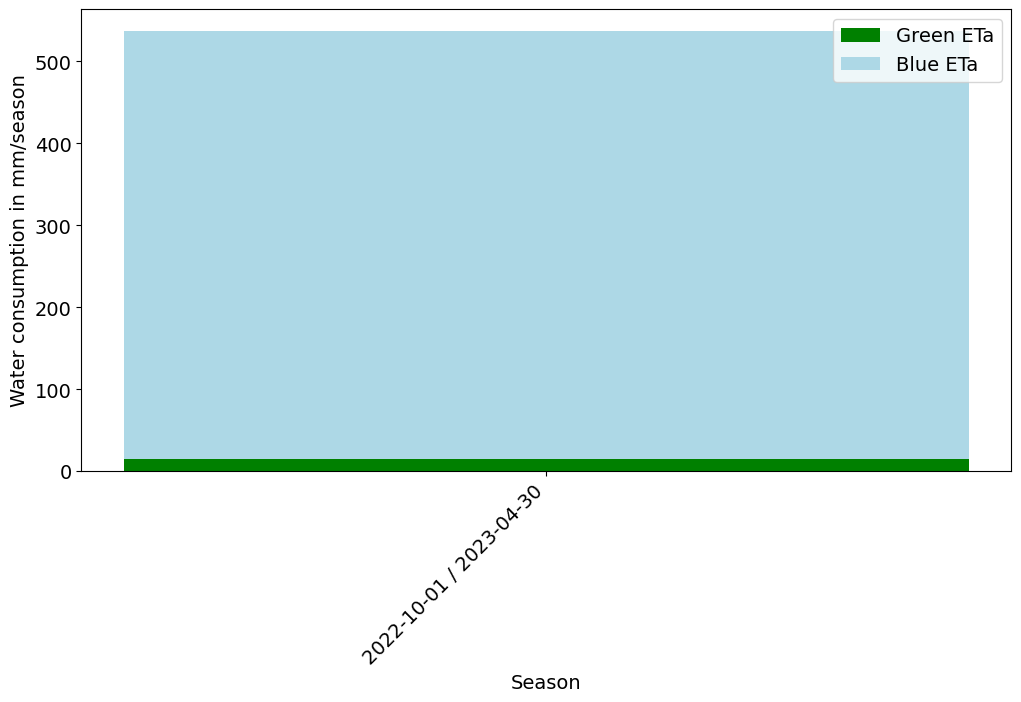

In [47]:
# Short description:
# This script plots a stacked bar chart of seasonal Green ETa and Blue ETa, representing green and blue water consumption.
# The x-axis represents seasons, and the y-axis shows water consumption in millimeters (mm) per season.

# Data set
x = df.Season[:]  # Seasons
y1 = df.GreenETa_mean[:]  # Green water consumption (ETa met by precipitation)
y2 = df.BlueETa_mean[:]  # Blue water consumption (ETa met by irrigation)

# Plot stacked bar chart
plt.subplots(figsize=(12, 6))
plt.bar(x, y1, color='g', label='Green ETa')  # Green ETa in green
plt.bar(x, y2, bottom=y1, color='lightblue', label='Blue ETa')  # Blue ETa stacked on Green ETa
plt.xlabel('Season', fontsize=14)
plt.ylabel('Water consumption in mm/season', fontsize=14)

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45, ha='right', fontsize=14)  # Rotate and align x-labels at 45 degrees
plt.yticks(fontsize=14)

# Add a legend to differentiate Green and Blue ETa
plt.legend(fontsize=14)

# Display the plot
plt.show()


## Step 7. Zip and download seasonal data

In [48]:
# 1) Compress the specified folders into a single zip file named WaPORv3_M2_Seasonal.zip
!zip -r /content/WaPORv3_M2_Seasonal.zip /content/output_M2/{ETp_season,GreenBlueET_season,PCP_season,RET_season}

# 2) Download the zipped file from Colab to your local machine
from google.colab import files
files.download(r'/content/WaPORv3_M2_Seasonal.zip')

  adding: content/output_M2/ETp_season/ (stored 0%)
  adding: content/output_M2/ETp_season/ETc_season1_2022-10-01_to_2023-04-30.tif (deflated 100%)
  adding: content/output_M2/GreenBlueET_season/ (stored 0%)
  adding: content/output_M2/GreenBlueET_season/BlueETa_2022-10-01_to_2023-04-30.tif (deflated 68%)
  adding: content/output_M2/GreenBlueET_season/Green&BlueETa.xlsx (deflated 11%)
  adding: content/output_M2/GreenBlueET_season/GreenETa_2022-10-01_to_2023-04-30.tif (deflated 100%)
  adding: content/output_M2/PCP_season/ (stored 0%)
  adding: content/output_M2/PCP_season/PCP_season1_2022-10-01_to_2023-04-30.tif (deflated 100%)
  adding: content/output_M2/RET_season/ (stored 0%)
  adding: content/output_M2/RET_season/RET_season1_2022-10-01_to_2023-04-30.tif (deflated 100%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>